# Dogs Vs Cats Classification with Pre-Trained Neural Network VGG16 Using Tensorflow and Keras

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

https://gist.github.com/fchollet/f35fbc80e066a49d65f1688a7e99f069

## Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.models import load_model, model_from_json
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import applications, optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg16 import preprocess_input

## Define constants

In [3]:
# dimensions of our images
img_width, img_height = 150, 150

PATH = 'data/dogscats_small/'
train_data_dir = f'{PATH}train/'
validation_data_dir = f'{PATH}validation/'
test_data_dir = f'{PATH}test/'
nb_train_samples = 2000
nb_validation_samples = 800
nb_test_samples = 2000
epochs = 50
batch_size = 16

In [4]:
# value stored in /users/<user>/keras/.keras.json file
# "channels_last" for tensorflow

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

## Util function

In [5]:
# retrieve random image, either cat or dog from the validation set
# only works for specific data file structures and file names!
def get_rand_image():
    rand_dog_cat = np.random.choice(('cat', 'dog'))
    rand_img_idx = np.random.randint(1000, 1400)
    rand_img_path = f"{validation_data_dir}{rand_dog_cat}s/{rand_dog_cat}.{rand_img_idx }.jpg"
    rand_img = image.load_img(rand_img_path, target_size=(img_width, img_height))
    
    return rand_img_path,rand_img

## Build pre-trained model (VGG16)

In [6]:
model = applications.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

## Save bottleneck features

In [7]:
os.makedirs('tmp', exist_ok=True)

# no data augmentation if we want to cache
datagen = ImageDataGenerator(rescale=1. / 255)

generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,  # this means our generator will only yield batches of data, no labels
        shuffle=False)  # our data will be in order, so all first 1000 images will be cats, then 1000 dogs

bottleneck_features_train = model.predict_generator(generator, nb_train_samples // batch_size)
np.save('tmp/bottleneck_features_train.npy', bottleneck_features_train)

Found 2000 images belonging to 2 classes.


In [8]:
# Feedforward calculation and caching for validation data
generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

bottleneck_features_validation = model.predict_generator(generator, nb_validation_samples // batch_size)
np.save('tmp/bottleneck_features_validation.npy', bottleneck_features_validation)

Found 800 images belonging to 2 classes.


## Load the cached calculations

In [9]:
train_data = np.load('tmp/bottleneck_features_train.npy')
train_labels = np.array([0] * (nb_train_samples // 2) + [1] * (nb_train_samples // 2))

validation_data = np.load('tmp/bottleneck_features_validation.npy')
validation_labels = np.array([0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2))

## Train top model (last layer - fully connected)

In [8]:
def build_last_layer(input_shape):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [11]:
last_layer_model = build_last_layer(train_data.shape[1:])
last_layer_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
%%time
training_log = last_layer_model.fit(train_data, train_labels,
                     epochs=epochs,
                     batch_size=batch_size,
                     validation_data=(validation_data, validation_labels))

Train on 2000 samples, validate on 800 samples
Epoch 1/50
2000/2000 [==============================] - 1s 583us/step - loss: 0.7128 - acc: 0.7685 - val_loss: 0.2826 - val_acc: 0.8912
Epoch 2/50
2000/2000 [==============================] - 1s 325us/step - loss: 0.3211 - acc: 0.8620 - val_loss: 0.3726 - val_acc: 0.8325
Epoch 3/50
2000/2000 [==============================] - 1s 326us/step - loss: 0.3030 - acc: 0.8800 - val_loss: 0.3269 - val_acc: 0.8738
Epoch 4/50
2000/2000 [==============================] - 1s 322us/step - loss: 0.2671 - acc: 0.8990 - val_loss: 0.3465 - val_acc: 0.8675
Epoch 5/50
2000/2000 [==============================] - 1s 323us/step - loss: 0.2191 - acc: 0.9185 - val_loss: 0.5416 - val_acc: 0.8113
Epoch 6/50
2000/2000 [==============================] - 1s 316us/step - loss: 0.2027 - acc: 0.9245 - val_loss: 0.4605 - val_acc: 0.8575
Epoch 7/50
2000/2000 [==============================] - 1s 327us/step - loss: 0.1783 - acc: 0.9305 - val_loss: 0.3689 - val_acc: 0.8862
E

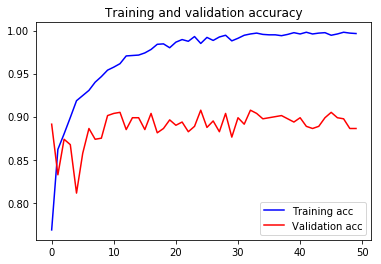

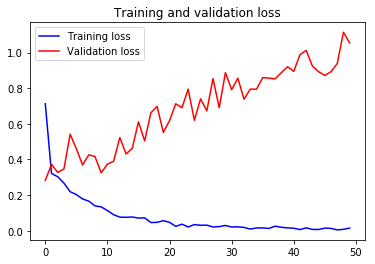

In [13]:
acc = training_log.history['acc']
val_acc = training_log.history['val_acc']
loss = training_log.history['loss']
val_loss = training_log.history['val_loss']
 
epochs_plt = range(len(acc))
 
plt.plot(epochs_plt, acc, 'b', label='Training acc')
plt.plot(epochs_plt, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs_plt, loss, 'b', label='Training loss')
plt.plot(epochs_plt, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

## Save model

### Save as full model

In [14]:
os.makedirs(f'{PATH}models/', exist_ok=True)

In [15]:
last_layer_model.save(f'{PATH}/models/vgg16a_bottleneck_fc_model.h5') # no need to save VGG16

### Save as architecture definition (json) + weights value

In [16]:
model_json = last_layer_model.to_json()

with open(f'{PATH}/models/vgg16a_bottleneck_fc_arch.json', 'w') as json_file:
    json_file.write(model_json)
    
last_layer_model.save_weights(f'{PATH}/models/vgg16a_bottleneck_fc_weights.h5')

## Load model to predict test data

In [17]:
test_base_model = applications.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

In [18]:
# both options should return the same model but we may want to 
# change the weights using those obtained from training
load_from_model_file = False

if load_from_model_file:
    test_last_layer_model = load_model(f'{PATH}/models/vgg16a_bottleneck_fc_model.h5')
else:
    json_file = open(f'{PATH}/models/vgg16a_bottleneck_fc_arch.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    test_last_layer_model = model_from_json(loaded_model_json)

    test_last_layer_model.load_weights(f'{PATH}/models/vgg16a_bottleneck_fc_weights.h5')

## Predict on single image

data/dogscats_small/validation/dogs/dog.1315.jpg


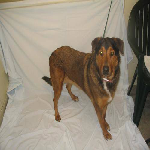

In [19]:
rand_img_path, rand_img = get_rand_image()
rand_dog_cat = 'dog' if 'validation/dogs' in rand_img_path else 'cat'

print(rand_img_path)
rand_img

In [20]:
x_test = image.img_to_array(rand_img)
x_test = x_test/255.0 # scaling as we have done in validation_datagen
x_test = np.expand_dims(x_test, axis=0) # increase dimension so that can be fed into model

In [21]:
bottleneck_features = test_base_model.predict(x_test)

In [22]:
pred = np.asscalar(np.squeeze(test_last_layer_model.predict_classes(bottleneck_features)))
prob = np.asscalar(np.squeeze(test_last_layer_model.predict_proba(bottleneck_features)))
prob2 = np.asscalar(np.squeeze(test_last_layer_model.predict_proba(bottleneck_features)))
pred,prob, prob2

(1, 1.0, 1.0)

In [23]:
res = 'dog' if pred==1 else 'cat'
pct = round(prob*100,2)
if res is 'cat':
    pct = 100 - pct 

print('The model is ' + str(pct) + '% sure this is a ' + res)

The model is 100.0% sure this is a dog


## Predict on batch of test images

Unlike validation data, these are never seen or tested before

In [24]:
def predict(data_dir, base_model, last_layer_model):
    preds = []
    
    for fn in os.listdir(data_dir):
        img = load_img(data_dir+fn, target_size=(img_width,img_height))
        x = img_to_array(img)
        x = x/255.0
        x = np.expand_dims(x, axis=0)
        
        features = base_model.predict(x)
        
        pred = np.asscalar(np.squeeze(last_layer_model.predict_classes(features)))
        preds.append(pred)
        
    return np.array(preds)

In [25]:
dog_test_dir = f"{test_data_dir}dogs/"
cat_test_dir = f"{test_data_dir}cats/"

In [26]:
pred_dogs = predict(dog_test_dir, test_base_model, test_last_layer_model)

In [27]:
pred_cats = predict(cat_test_dir, test_base_model, test_last_layer_model)

In [28]:
cat_acc = (1-pred_cats.mean())*100
dog_acc = pred_dogs.mean()*100

print(f'Cat Prediction Accuracy: {cat_acc:.2f}%\nDog Prediction Accuracy: {dog_acc:.2f}%')

Cat Prediction Accuracy: 91.60%
Dog Prediction Accuracy: 84.50%


Compared the results above to baseline model:

    - Cat Prediction Accuracy: 77.70%
    - Dog Prediction Accuracy: 81.80%

## Fine-tuning

### Setup base and last layer models and combine them

In [21]:
tune_base_model = applications.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

In [22]:
x = tune_base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

In [30]:
# # both options should return the same model but we may want to 
# # change the weights using those obtained from training
# load_from_model_file = False

# if load_from_model_file:
#     tune_last_layer_model = load_model(f'{PATH}/models/vgg16_bottleneck_fc_model.h5')
# else:
#     json_file = open(f'{PATH}/models/vgg16_bottleneck_fc_arch.json', 'r')
#     loaded_model_json = json_file.read()
#     json_file.close()
#     tune_last_layer_model = model_from_json(loaded_model_json)

#     tune_last_layer_model.load_weights(f'{PATH}/models/vgg16_bottleneck_fc_weights.h5')

In [14]:
# x = tune_base_model.output
# x = tune_last_layer_model(x)

In [23]:
tune_final_model = Model(inputs=tune_base_model.input, outputs=x)

In [24]:
# Freeze the first 5 layers, train the rest
for layer in tune_final_model.layers[:5]:
    layer.trainable = False

In [25]:
# Compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
tune_final_model.compile(loss='binary_crossentropy',
                       optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
                       metrics=['accuracy'])

In [26]:
# prepare data augmentation configuration
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

In [27]:
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(validation_data_dir,
                                                              target_size=(img_height, img_width),
                                                              batch_size=batch_size,
                                                              class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


### Train the model using last layer with trained weights

In [37]:
%%time
tune_training_log = tune_final_model.fit_generator(train_generator,
                             steps_per_epoch=nb_train_samples // batch_size,
                             epochs=epochs,
                             validation_data=validation_generator,
                             validation_steps=nb_validation_samples // batch_size)

Epoch 1/50
125/125 [==============================] - 36s 291ms/step - loss: 0.6144 - acc: 0.8560 - val_loss: 0.3211 - val_acc: 0.8800
Epoch 2/50
125/125 [==============================] - 33s 266ms/step - loss: 0.2344 - acc: 0.9235 - val_loss: 0.1581 - val_acc: 0.9337
Epoch 3/50
125/125 [==============================] - 34s 270ms/step - loss: 0.1753 - acc: 0.9405 - val_loss: 0.1428 - val_acc: 0.9463
Epoch 4/50
125/125 [==============================] - 34s 271ms/step - loss: 0.0924 - acc: 0.9635 - val_loss: 0.2001 - val_acc: 0.9213
Epoch 5/50
125/125 [==============================] - 33s 266ms/step - loss: 0.0799 - acc: 0.9715 - val_loss: 0.1718 - val_acc: 0.9400
Epoch 6/50
125/125 [==============================] - 33s 266ms/step - loss: 0.0531 - acc: 0.9795 - val_loss: 0.1338 - val_acc: 0.9475
Epoch 7/50
125/125 [==============================] - 33s 267ms/step - loss: 0.0562 - acc: 0.9810 - val_loss: 0.1114 - val_acc: 0.9625
Epoch 8/50
125/125 [==============================] - 3

### Train the model using last layer without trained weights

In [28]:
# using last layer without trained weights
%%time
tune_training_log = tune_final_model.fit_generator(train_generator,
                             steps_per_epoch=nb_train_samples // batch_size,
                             epochs=epochs,
                             validation_data=validation_generator,
                             validation_steps=nb_validation_samples // batch_size)

Epoch 1/50
125/125 [==============================] - 38s 303ms/step - loss: 0.6179 - acc: 0.6640 - val_loss: 0.4662 - val_acc: 0.8250
Epoch 2/50
125/125 [==============================] - 33s 267ms/step - loss: 0.3839 - acc: 0.8470 - val_loss: 0.2822 - val_acc: 0.9000
Epoch 3/50
125/125 [==============================] - 34s 270ms/step - loss: 0.2659 - acc: 0.8920 - val_loss: 0.3519 - val_acc: 0.8337
Epoch 4/50
125/125 [==============================] - 34s 271ms/step - loss: 0.2317 - acc: 0.9050 - val_loss: 0.1924 - val_acc: 0.9313
Epoch 5/50
125/125 [==============================] - 34s 275ms/step - loss: 0.1720 - acc: 0.9335 - val_loss: 0.1524 - val_acc: 0.9363
Epoch 6/50
125/125 [==============================] - 34s 270ms/step - loss: 0.1731 - acc: 0.9360 - val_loss: 0.1608 - val_acc: 0.9363
Epoch 7/50
125/125 [==============================] - 34s 271ms/step - loss: 0.1500 - acc: 0.9395 - val_loss: 0.1781 - val_acc: 0.9237
Epoch 8/50
125/125 [==============================] - 3

### Assess the model by predict unseen test data

In [31]:
def tuned_model_predict(data_dir, model):
    preds = []
    for fn in os.listdir(data_dir):
        img = load_img(data_dir+fn, target_size=(img_width,img_height))
        x = img_to_array(img)
        x = x/255.0
        x = np.expand_dims(x, axis=0)
        
        pred = np.asscalar(np.squeeze(model.predict(x)))
        preds.append(pred)

    return np.array(preds)

In [32]:
dog_test_dir = f"{test_data_dir}dogs/"
cat_test_dir = f"{test_data_dir}cats/"

pred_dogs = tuned_model_predict(dog_test_dir, tune_final_model)
pred_cats = tuned_model_predict(cat_test_dir, tune_final_model)

In [41]:
cat_acc = len(pred_cats[pred_cats<0.5])/len(pred_cats) * 100
dog_acc = len(pred_dogs[pred_dogs>=0.5])/len(pred_dogs) * 100

print(f'Cat Prediction Accuracy: {cat_acc:.2f}%\nDog Prediction Accuracy: {dog_acc:.2f}%')

Cat Prediction Accuracy: 97.40%
Dog Prediction Accuracy: 95.60%


Compared to previous results:

- Train only the last layer: 
    - Cat Prediction Accuracy: 91.60%
    - Dog Prediction Accuracy: 84.50%

- Baseline:
    - Cat Prediction Accuracy: 77.70%
    - Dog Prediction Accuracy: 81.80%

Without trained weights

In [33]:
cat_acc = len(pred_cats[pred_cats<0.5])/len(pred_cats) * 100
dog_acc = len(pred_dogs[pred_dogs>=0.5])/len(pred_dogs) * 100

print(f'Cat Prediction Accuracy: {cat_acc:.2f}%\nDog Prediction Accuracy: {dog_acc:.2f}%')

Cat Prediction Accuracy: 92.00%
Dog Prediction Accuracy: 97.70%
